# Setup

In [13]:
""" Run the latest and greatest """
%pip install --upgrade pip
%pip install -r requirements.txt --upgrade

Note: you may need to restart the kernel to use updated packages.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.


In [1]:
from bs4 import BeautifulSoup
from collections import Counter
import html5lib
import itertools
import json
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
import shifterator as sh
import string
from string import punctuation as punct
import sys
# import tensorflow as tf

print('Running the following Package Versions:')
print('---------------------------------------')

print(f'Matplotlib      V.{mpl.__version__}')
print(f'NumPy           V.{np.__version__}')
print(f'Pandas          V.{pd.__version__}')
print(f'Seaborn         V.{sns.__version__}')
# print(f'TensorFlow      V.{str(tf.__version__)[:6]}')

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

""" In case Computer Modern Roman size 10 isn't an option. """
# mpl.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

""" Set default font for plots. """
mpl.rc('font',
       family = 'serif',
       serif = 'cmr10')
mpl.rc('mathtext',
       fontset = 'cm')

wd = os.getcwd()

%matplotlib inline

Running the following Package Versions:
---------------------------------------
Matplotlib      V.3.5.3
NumPy           V.1.21.6
Pandas          V.1.1.5
Seaborn         V.0.12.2


# Functions

In [2]:
def load_text(f: str = '~/content/text.txt',
              prnt: bool = True):
  with open(f, encoding = 'utf-8') as txt:
    gram_list = re.findall(r"\w+[^\s\.,?!;]+|\w+|[\.,?!;]",
                          ''.join(txt.readlines()))
    if prnt:
      print(f"Total n-grams: {len(np.array(gram_list)):>14,}")
  return np.array(gram_list)

def get_word_freq(f: str = '~/content/text.txt',
                  prnt: bool = True):
  n_gram_vec = load_text(f)
  freq = np.array(np.unique(n_gram_vec, return_counts=True, axis=None))
  if prnt:
    print(f'Total unique n-grams: {len(np.array(freq[1])):>7,}')
  return freq, n_gram_vec

def plot_zipf(f: str = '~/content/text.txt'):
  freq = load_text(f)
  plt.scatter(x = np.linspace(len(freq),1,len(freq)), 
              y = freq,
              s = 2,
              c = 'k',
              alpha = 0.8,
              linewidths=0.)
  plt.xscale('log')
  plt.yscale('log')
  plt.suptitle('Prior',
              fontsize = 16)
  plt.title('Rank-Frequency (Zipf) Plot')
  plt.xlabel(r'log$_{10}$(Rank)')
  plt.ylabel(r'log$_{10}$(Frequency)')
  sns.despine()
  plt.show()

def subdue_ts_df(df, dh):
  return pd.DataFrame([i for i in df if i <= df.mean() - dh or i <= df.mean() + dh]).interpolate(method='linear')

def lens_ts_df(df, w):
   return pd.DataFrame(df.rolling(int(w)).sum() / w).interpolate(method='linear')

def gen_ts_df(source):
  ts = np.char.lower(load_text(source, False))
  wd = os.getcwd()
  sentiment_lmt1 = pd.read_table(f'{wd}/data/nlp/ref/dataset_s1.tsv')
  sentiment_lmt1.set_index(sentiment_lmt1['word'], inplace = True)
  ind_list = [sentiment_lmt1.index.get_loc(word) for word in ts if word in sentiment_lmt1.index]
  return sentiment_lmt1.iloc[ind_list]['happiness_average']

def gen_ts_windows(ts_df: pd.core.frame.DataFrame = None,
                   dh: float = 0.,
                   t: list = None, 
                   fixed_y: bool = False, 
                   show_plot: bool = False, 
                   ax = None):
  if t is None:
    t = [10**1, 10**1.5, 10**2, 10**2.5, 10**3, 10**3.5, 10**4]

  if ax is None:
    fig, axs = plt.subplots(7, 1, figsize = (3.5, 9), dpi = 180)

  else:
    return overplot(ts_df, t, ax, fixed_y)

  for i, ax in enumerate(axs):
      temp = ts_df
      temp = lens_ts_df(ts_df, t[i])
      temp.plot(ax = ax,
                alpha = 2/3,
                linewidth = 1/3,
                color='maroon',
                legend = False)
      ax.set_title(r'$\delta_h=0; T=$'+f'{int(t[i])}',
                      fontsize = 7)

      n = len(temp)
      ticks = [int(i) for i in np.linspace(1, n, 6)]
      ax.set_xticks(ticks)
      ax.set_xlabel('')
      if fixed_y:
        ax.set_yticks(np.linspace(3.7, 6.1, 4))
        ax.set_yticklabels(labels = np.linspace(3.7, 6.1, 4),fontsize = 6)

      if i == 6:
          ax.set_xticklabels([], fontsize = 6)
          ax.set_xlabel('Word Index', fontsize = 6)

  if show_plot:
    plt.suptitle('Average Lexical Happiness',
                 fontsize = 10)
    plt.tight_layout()
    plt.savefig(fname = f'bm_T{int(t[i])}.jpg')
    plt.show()
  return axs

def overplot(ts_df, t, ax, fixed_y):
  temp = ts_df
  temp = lens_ts_df(ts_df, t)
  temp.plot(ax = ax,
            alpha = 2/3,
            linewidth = 1/3,
            color='maroon',
            legend = False)
  ax.set_title(r'$\delta_h=0; T=$'+f'{int(t)}',
                  fontsize = 7)

  n = len(temp)
  ticks = [int(i) for i in np.linspace(1, n, 6)]
  ax.set_xticks(ticks)
  ax.set_xlabel('')
  if fixed_y:
    ax.set_yticks(np.linspace(3.7, 6.1, 4))
    ax.set_yticklabels(labels = np.linspace(3.7, 6.1, 4),fontsize = 6)
  return ax

def gen_ts_delta_h(ts_df: pd.core.frame.DataFrame = None, 
                   dh: list = None, 
                   t: float = 10**3.5, 
                   fixed_y: bool = False, 
                   show_plot: bool = False, 
                   ax = None):
  if dh is None:
    dh = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]

  if ax is None:
    fig, axs = plt.subplots(7, 1, figsize = (3.5, 9), dpi = 180)

  else:
    for i in dh:
      temp = ts_df
      temp = subdue_ts_df(ts_df, i)
      temp = lens_ts_df(ts_df, t)
      ax.plot(np.linspace(0, len(ts_df), len(temp)),
              temp.values,
              alpha = 2/3,
              linewidth = 1/3)
    return ax
  
  for i, ax in enumerate(axs):
      temp = subdue_ts_df(ts_df, dh[i])
      temp = lens_ts_df(temp, t)
      temp.plot(ax = ax,
                alpha = 2/3,
                linewidth = 1/3,
                color='maroon',
                legend = False)
      ax.set_title(r'$\delta_h=$'+f'{dh[i]}; '+r'$T=$'+f'{int(t)}',
                   fontsize = 7)

      n = len(temp)
      ticks = [int(i) for i in np.linspace(1, n, 6)]
      ax.set_xticks(ticks)
      
      if fixed_y:
        ax.set_yticks([5.2,5.3,5.4])
        ax.set_yticklabels(labels = [5.2,5.3,5.4],fontsize = 6)

      if i != 3.5:
          ax.set_xticklabels([], fontsize = 6)

  if show_plot:
    plt.suptitle('Average Lexical Happiness',
                 fontsize = 10)
    plt.tight_layout()
    plt.savefig(fname = f'bm_T{int(t[i])}.jpg')
    plt.show()
  return axs

def stacked_plot(ts_df, 
                 t, 
                 show_plot = False):
    re_df = pd.DataFrame()
    dh = np.arange(0.5,4,0.5)
    for i in dh:
        temp = subdue_ts_df(ts_df, i)
        temp = lens_ts_df(temp, t)
        re_df = pd.concat(
           (re_df, temp.rename(columns={0:i})),
           axis=1,
           ignore_index=True,
           keys=list(re_df.columns).append(i),
           names=['delta_h', None])
    if show_plot:
        fig, ax = plt.subplots(
            1,1,
            sharey=True,
            figsize=(7.5, 3.5),
            dpi=180)
        re_df.interpolate(method='linear').plot(
            ax=ax,
            alpha=0.8,
            linewidth=0.5,
            colormap='gnuplot',
            marker='.')
        fig.show()
    return re_df

def gen_shift_args(wf_1 : dict = None, 
                   wf_2 : dict = None, 
                   raise_err : bool = False, 
                   prop_shift : bool = False, 
                   set_ref : bool = False, 
                   lens: list = None,
                   source: str = None):
    
  if lens is None:
    lens = [(3,7)]

  if raise_err or prop_shift:
      raise_err = 'error'
      types = set(wf_1.keys()).union(wf_2.keys())
      for t in types:
          if t not in wf_1:
              wf_1[t] = 0
          elif t not in wf_2:
              wf_2[t] = 0

  else:
     raise_err = 'exclude'

  if set_ref:
     ref = np.mean(subdue_ts_df(gen_ts_df(source = source), lens[0][0]-lens[0][1])[0])

  else:
     ref = 0

  print("Lensing Window: [{}, {}]".format(lens[0][0], lens[0][1]))
  print("Reference Happiness: {:4.3f}".format(ref))

  wa_args = { 
      'type2freq_1' : wf_1,
      'type2freq_2' : wf_2,
      'type2score_1' :  'labMT_English',
      'type2score_2' : 'labMT_English',
      'reference_value' : ref,
      'handle_missing_scores' : raise_err,
      'stop_lens' : lens,
      'stop_words' : None,
      'normalization' : "variation",
      'source' : source
  }

  ps_args = {
      'type2freq_1' : wf_1,
      'type2freq_2' : wf_2,
      'type2score_1' :  'labMT_English',
      'type2score_2' : 'labMT_English',
      'reference_value' : ref,
      'handle_missing_scores' : raise_err,
      'stop_lens' : lens,
      'stop_words' : None,
      'normalization' : "variation"
  }

  en_args = {
      'type2freq_1' : wf_1,
      'type2freq_2' : wf_2,
      'base' : 2,
      'alpha' : 1,
      'reference_value' : ref,
      'normalization' : "variation",
      'source' : source
  }

  kl_args = {
      'type2freq_1' : wf_1,
      'type2freq_2' : wf_2,
      'base' : 2,
      'reference_value' : ref,
      'normalization' : "variation",
  }

  js_args = {
      'type2freq_1' : wf_1,
      'type2freq_2' : wf_2,
      'base' : 2,
      'weight_1' : 0.5,
      'weight_2' : 0.5,
      'alpha' : 1,
      'reference_value' : ref,
      'normalization' : "variation",
      'source' : source
  }

  return {'weighted_average' : wa_args,
          'proportion_shift' : ps_args, 
          'entropy_shift' : en_args, 
          'kl_shift' : kl_args, 
          'jsd_shift' : js_args}

##########################################################################################
#                                     TEST  FUNCTIONS                                    #
##########################################################################################

def test_plot(ts_df: pd.core.frame.DataFrame = None):
  fig, ax = plt.subplots(1, 1, figsize=(20,5), dpi=250)
  ts_df.plot(linewidth=0.05, alpha = 0.95, ax = ax)
  ax.set_xticklabels([int(i) for i in np.linspace(1,len(ts_df), 8)])
  plt.show()

def test_str(n_gram: np.ndarray = None,
             prnt: bool = True):
  test_str = ' '.join(n_gram)
  if prnt:
    print(test_str)
  elif test_str:
    print("Non-zero string created.")
  else:
    print('You probably messed up. Try again!')

def test_window(df):
    return df.applymap(lambda x: df.rolling(int(x).sum())/x)

def test_lens(df, dh):
    return df.applymap(lambda x: x if df[x] >= df.mean() - dh and df[x] <= df.mean() + dh else np.nan)

##########################################################################################
#                                                                                        #
##########################################################################################

In [6]:
def read_final(f: str = None):
    import os
    wd = os.getcwd()
    df = pd.read_csv(f'{wd}/data/final_words.csv')
    for name in df['name'].unique():
        f = f"{name}_spoken.txt"
        with open(f, 'w') as txt:
            txt.writelines(' '.join(df['words'][df['name'] == name]))

read_final()

# Generate Word Shift

### Plot Word Shifts

Sample 1:
Total n-grams:            147
Total unique n-grams:      84

Sample 2:
Total n-grams:            120
Total unique n-grams:      89
Lensing Window: [4, 6]
Reference Happiness: 5.766


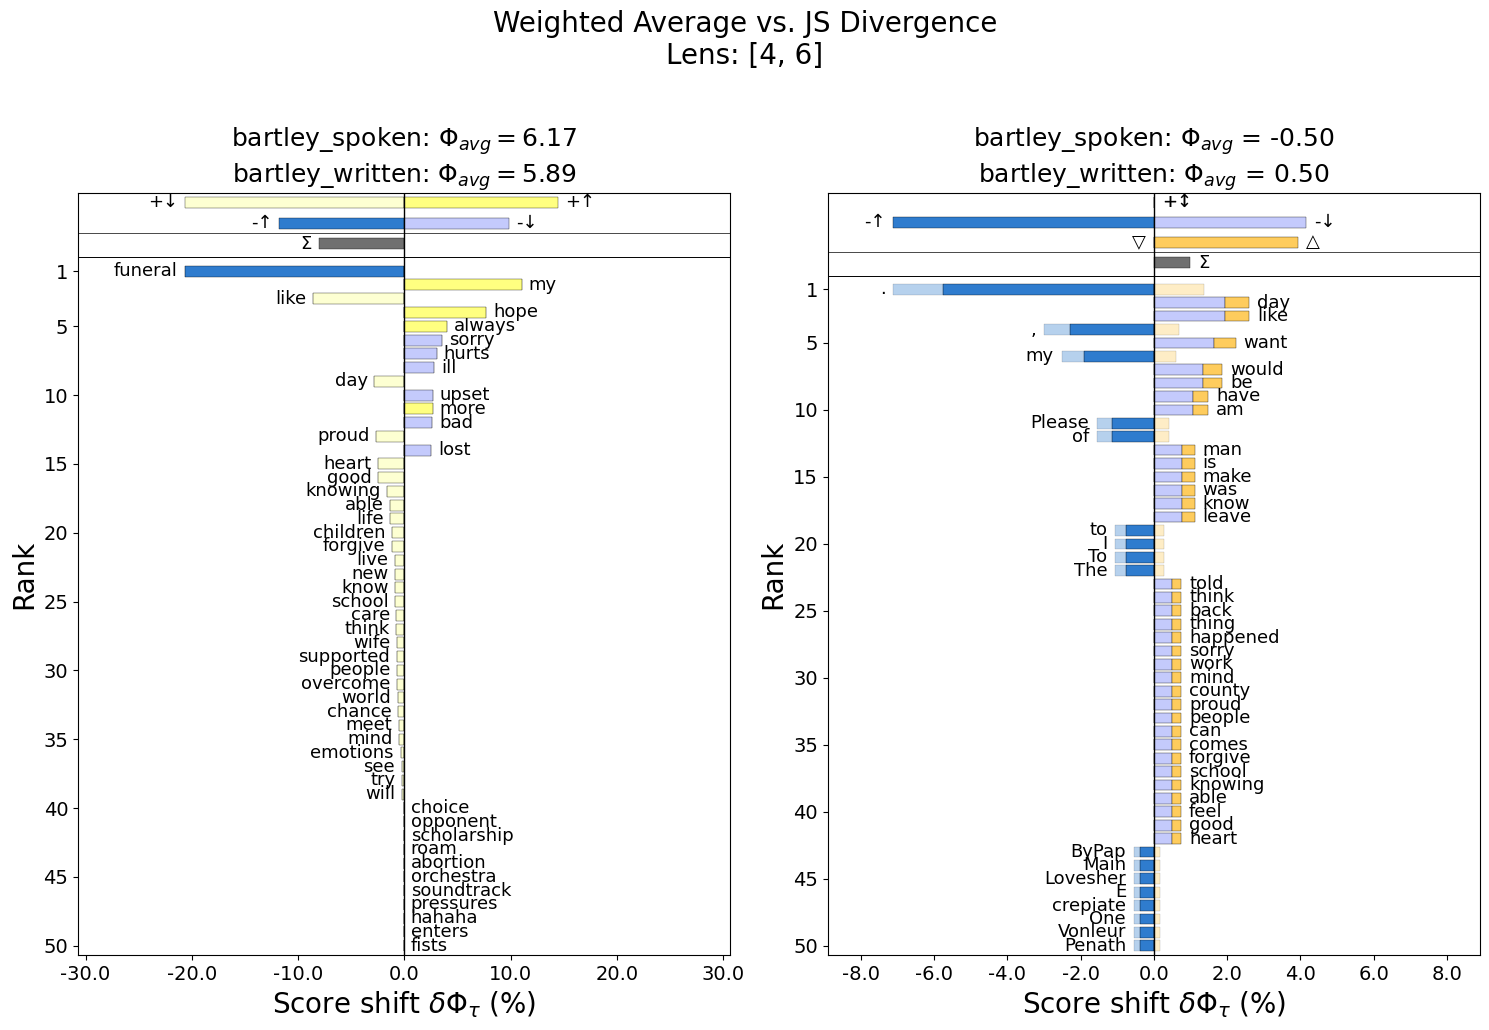

Sample 1:
Total n-grams:             87
Total unique n-grams:      57

Sample 2:
Total n-grams:             80
Total unique n-grams:      57
Lensing Window: [4, 6]
Reference Happiness: 5.906


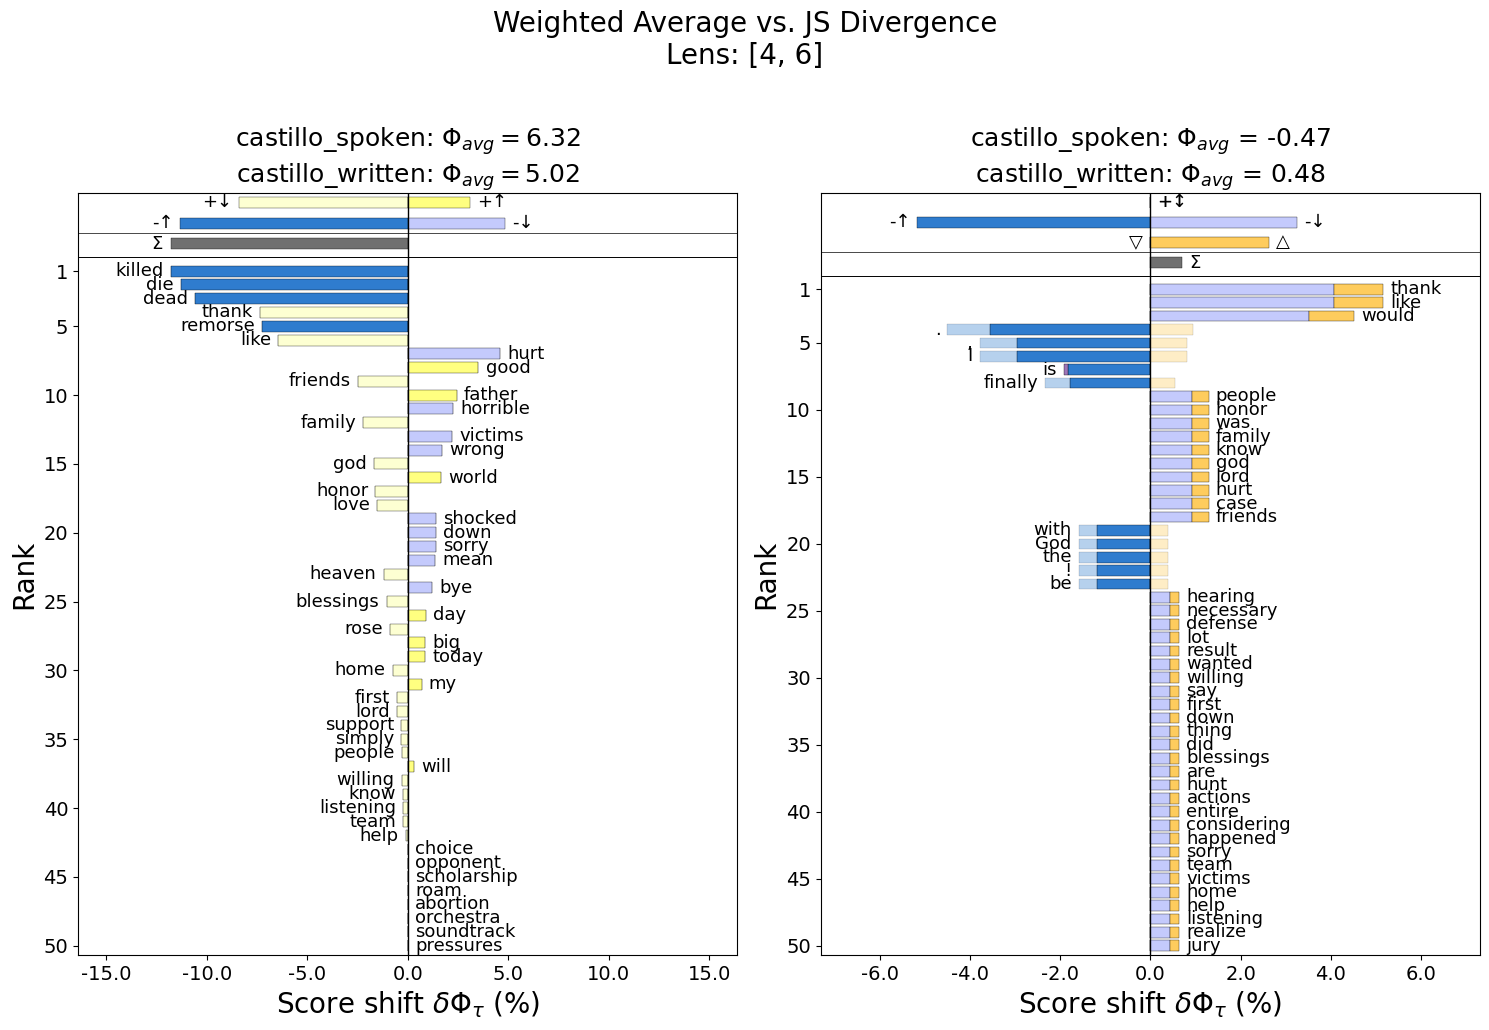

Sample 1:
Total n-grams:          1,597
Total unique n-grams:     677

Sample 2:
Total n-grams:            170
Total unique n-grams:     111
Lensing Window: [4, 6]
Reference Happiness: 5.365


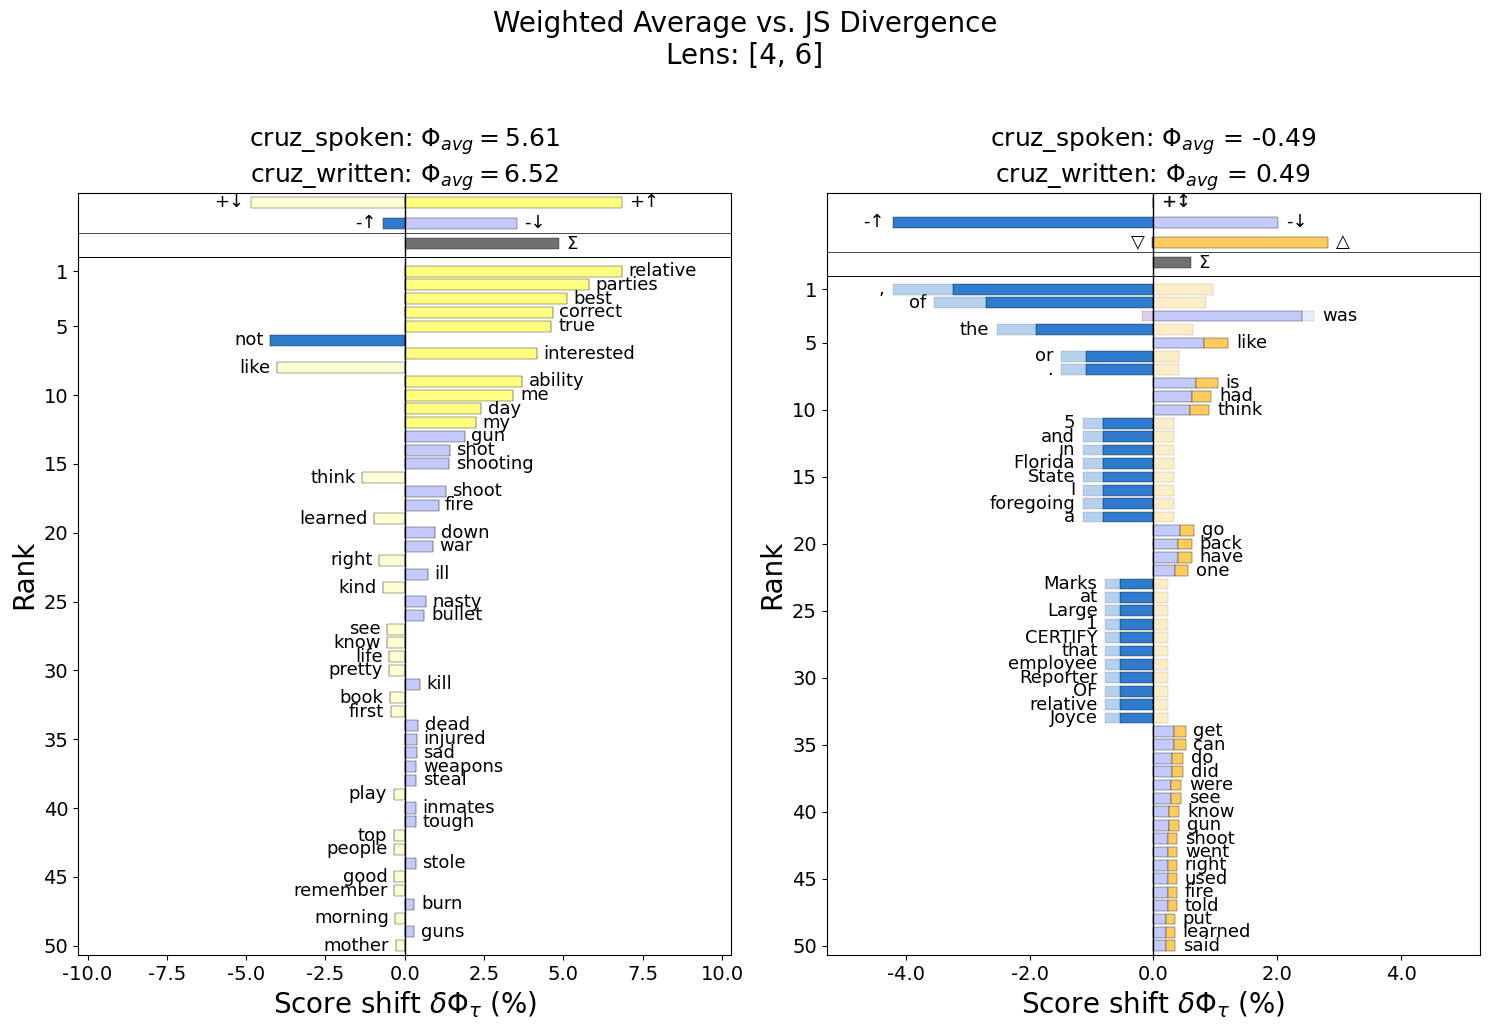

Sample 1:
Sample 1:
Total n-grams:            282
Total unique n-grams:     176

Sample 2:
Total n-grams:            466
Total unique n-grams:     245
Lensing Window: [4, 6]
Reference Happiness: 5.209


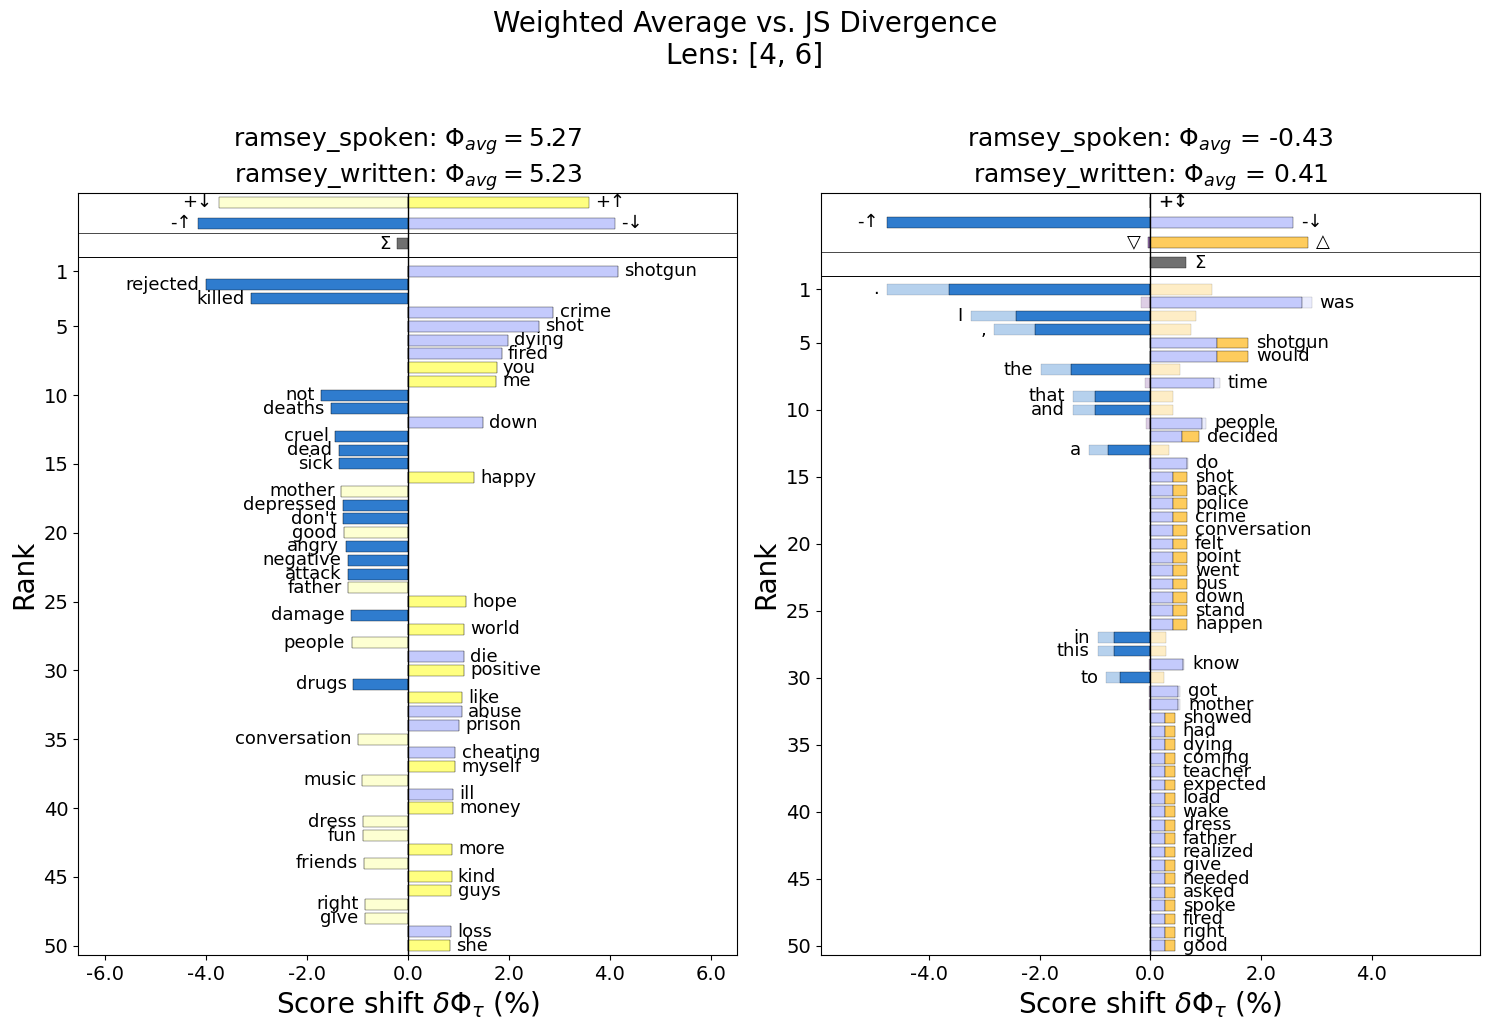

Sample 1:
Total n-grams:            550
Total unique n-grams:     251

Sample 2:
Total n-grams:            370
Total unique n-grams:     213
Lensing Window: [4, 6]
Reference Happiness: 5.527


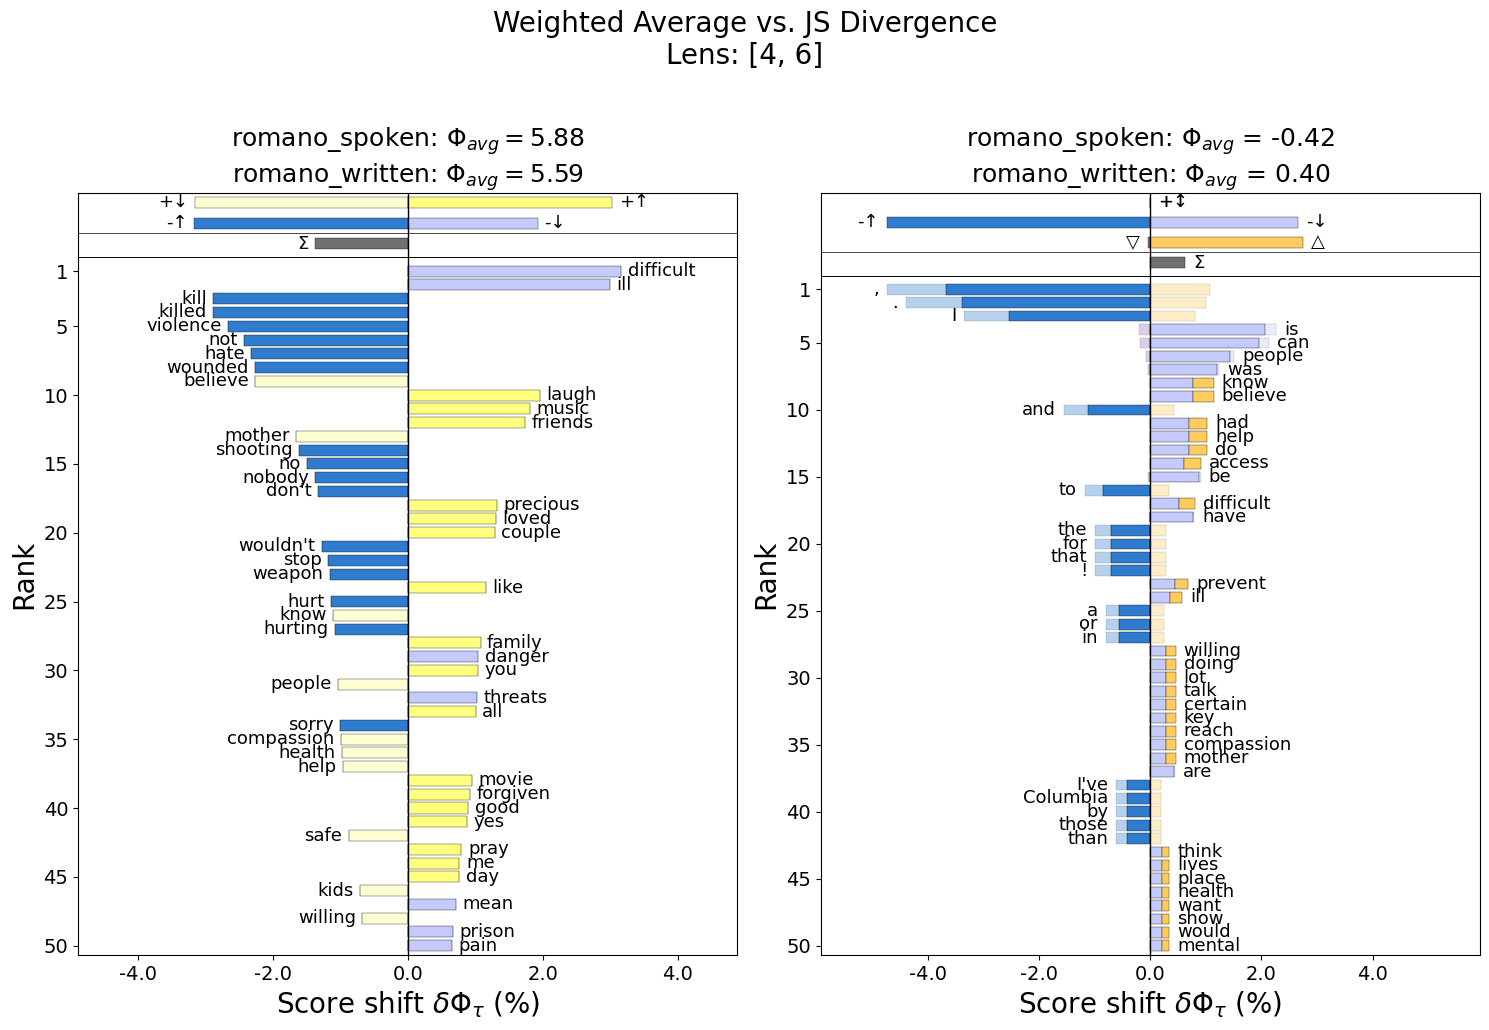

Sample 1:
Total n-grams:            928
Total unique n-grams:     366

Sample 2:
Total n-grams:            602
Total unique n-grams:     257
Lensing Window: [4, 6]
Reference Happiness: 5.429


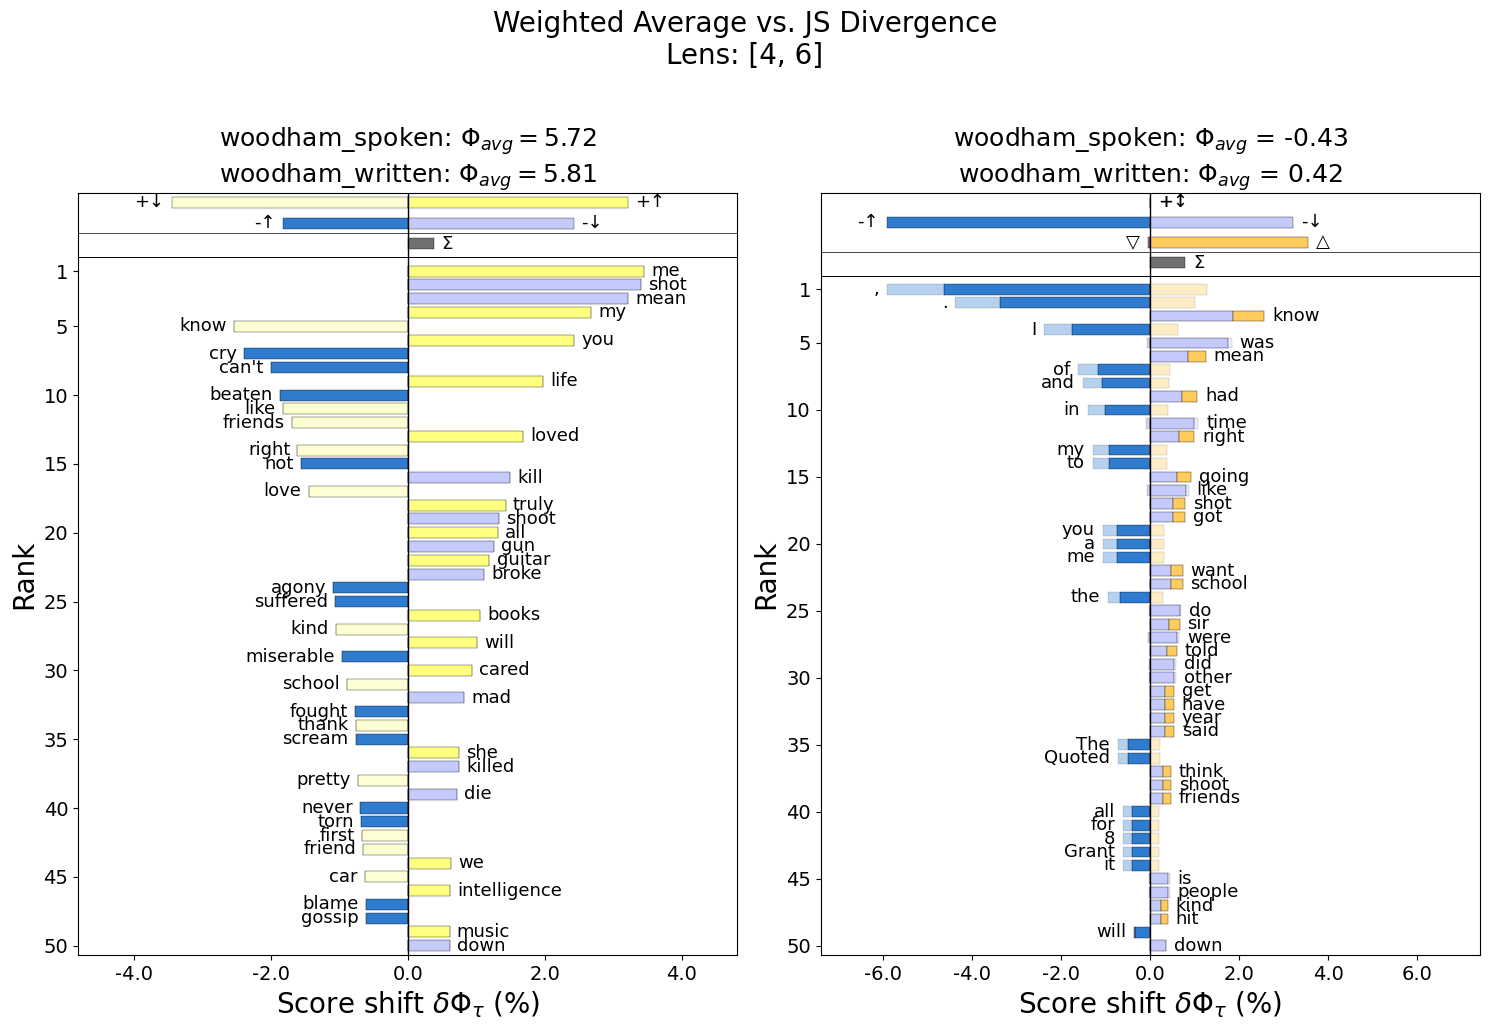

In [12]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

extension = f'{wd}/data/txt/'
list_txt = os.listdir(extension)
pairwise_txts = itertools.combinations(list_txt, 2)
comparisons = [
    ('bartley_spoken.txt', 'bartley_written.txt'),
    ('castillo_spoken.txt', 'castillo_written.txt'),
    ('cruz_spoken.txt', 'cruz_written.txt'),
    ('holmes_spoken.txt', 'holmes_written.txt'),
    ('ramsey_spoken.txt', 'ramsey_written.txt'),
    ('romano_spoken.txt', 'romano_written.txt'),
    ('woodham_spoken.txt', 'woodham_written.txt')]

for i in comparisons:
    try:
        first_txt: str = f'{extension}{i[0]}'
        second_txt: str = f'{extension}{i[1]}'

        print('Sample 1:')
        first_wf, first_ng = get_word_freq(first_txt)
        first_ts_df = gen_ts_df(first_txt)

        print('\nSample 2:')
        second_wf, second_ng = get_word_freq(second_txt)
        second_ts_df = gen_ts_df(second_txt)

        first_wf_dict = {i[0] : int(i[1]) for i in zip(first_wf[0,:], first_wf[1,:])}
        second_wf_dict = {i[0] : int(i[1]) for i in zip(second_wf[0,:], second_wf[1,:])}

        args = gen_shift_args(
            first_wf_dict, 
            second_wf_dict,
            set_ref = True,
            lens = [(4, 6)],
            source = first_txt
        )

        source = args['jsd_shift'].pop('source')
        source = args['weighted_average'].pop('source')

        fig = plt.figure(1, figsize = (15,10), layout = 'tight')

        sent_shift_was = sh.WeightedAvgShift(**args['weighted_average'])

        sent_shift_ent = sh.JSDivergenceShift(**args['jsd_shift'])

        system_names = [f'{i[0][:-4]}', f'{i[1][:-4]}']

        ax1 = fig.add_subplot(121)
        sent_shift_was.get_shift_graph(
            ax = ax1,
            detailed = True,
            show_plot = False,
            text_size_inset = False,
            cumulative_inset = False,
            system_names = system_names
        )

        s_avg_1 = sent_shift_ent.get_weighted_score(sent_shift_ent.type2freq_1, sent_shift_ent.type2score_1)
        s_avg_2 = sent_shift_ent.get_weighted_score(sent_shift_ent.type2freq_2, sent_shift_ent.type2score_2)

        title = (
            "{}: ".format(system_names[0])
            + r"$\Phi_{avg}$"
            + " = {0:.2f}".format(s_avg_1)
            + "\n"
            + "{}: ".format(system_names[1])
            + r"$\Phi_{avg}$"
            + " = {0:.2f}".format(s_avg_2)
        )

        ax2 = fig.add_subplot(122)
        sent_shift_ent.get_shift_graph(
            ax = ax2,
            detailed = True,
            show_plot = False,
            text_size_inset = False,
            cumulative_inset = False,
            title = title)

        fig.suptitle(
            'Weighted Average vs. JS Divergence\nLens: [4, 6]', 
            fontsize = 20,
            x = 0.5,
            y = 1.025
        )

        plt.show()
    except Exception:
        continue